# Task 1 Implement and Train a VAE##

Implement a VAE using (de)convolutional neural networks with pytorch.  
1 Construct your model so that its latent space Z is K-dimensional, with K > 1, and such that  
p(X | z) is (multivariate) Gaussian with independent components, i.e. such that  

p(X | z) =  
∏<sub>d=1</sub><sup>D</sup> p(X<sub>d</sub> | z) =  
∏<sub>d=1</sub><sup>D</sup> 𝒩(X<sub>d</sub> | μ<sub>d</sub>(z), σ²<sub>d</sub>(z)) for all z ∈ Z,  

where D ∈ ℕ is the number of features in the data, where  
X = (X₁, ..., X_D), and where  
μ(z) = (μ₁(z), ..., μ_D(z)) and  
σ²(z) = (σ²₁(z), ..., σ²_D(z))  
are the outputs of the decoder network of the VAE, when evaluated in z.  

Make sure your code can load and use the MNIST (digits) dataset; verify that it contains 60,000 training images and 10,000 testing images. Normalize the pixel values so they are represented as numerical values in the range [0, 1] (by dividing by 255). Split the training data such that you can use the first 50,000 images for training, and the last 10,000 images for validation.

Implement a routine to train your model on the 50,000 training images by maximising the (estimated) ELBO, using pytorch’s autodiff functionality and built-in optimisers (e.g. Adam). Use a batch size of your choice. Use your code to answer the following questions:

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:


class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)
        # Decoder
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(16, 2, 4, stride=2, padding=1)   # 14x14 -> 28x28

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc(z))
        h = h.view(-1, 32, 7, 7)
        h = F.relu(self.deconv1(h))
        h = self.deconv2(h)
        mu, logvar = h[:, :1, :, :], h[:, 1:, :, :]  # Split output into mu and logvar
        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar = self.decode(z)
        return recon_mu, recon_logvar, mu, logvar

# ===========================
# Gaussian log-likelihood reconstruction loss
# ===========================

def loss_function(recon_mu, recon_logvar, x, mu, logvar):
    # Gaussian likelihood log p(x|z)
    recon_var = torch.exp(recon_logvar)
    log_px_z = -0.5 * (torch.log(2 * torch.pi * recon_var) + ((x - recon_mu)**2) / recon_var)
    log_px_z = log_px_z.sum()  # Sum over all pixels and batch

    # KL divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -log_px_z + KLD, -log_px_z, KLD

# Data loading and splitting
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(mnist, [50000, 10000])
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_ds, batch_size=batch_size)
dl_test = DataLoader(test_ds, batch_size=batch_size)

# Initialize model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gaussian = ConvVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(gaussian.parameters(), lr=1.1e-3)



Epoch 01, Train ELBO: 500.8239, Val ELBO: 1141.9101
Epoch 02, Train ELBO: 988.5997, Val ELBO: 1151.0387
Epoch 03, Train ELBO: 1214.3630, Val ELBO: 1046.9774
Epoch 04, Train ELBO: 1316.9253, Val ELBO: 767.4214
Epoch 05, Train ELBO: 1376.4487, Val ELBO: 1941.4948
Epoch 06, Train ELBO: 1618.0026, Val ELBO: 1587.2570
Epoch 07, Train ELBO: 1534.5240, Val ELBO: 1317.6509
Epoch 08, Train ELBO: 1716.8893, Val ELBO: 2165.8909
Epoch 09, Train ELBO: 1652.4090, Val ELBO: 1985.9494
Epoch 10, Train ELBO: 1760.7250, Val ELBO: 2195.6566
Epoch 11, Train ELBO: 1596.5304, Val ELBO: 1464.8625
Epoch 12, Train ELBO: 1891.0742, Val ELBO: 1059.5454
Epoch 13, Train ELBO: 1950.6655, Val ELBO: 1072.3094
Epoch 14, Train ELBO: 2052.1325, Val ELBO: 1273.7983
Epoch 15, Train ELBO: 1824.1897, Val ELBO: 2019.3530
Epoch 16, Train ELBO: 2153.2431, Val ELBO: 1828.3920
Epoch 17, Train ELBO: 1890.2113, Val ELBO: 1811.9326
Epoch 18, Train ELBO: 1729.5454, Val ELBO: 2188.8759
Epoch 19, Train ELBO: 2093.5933, Val ELBO: 2039.3

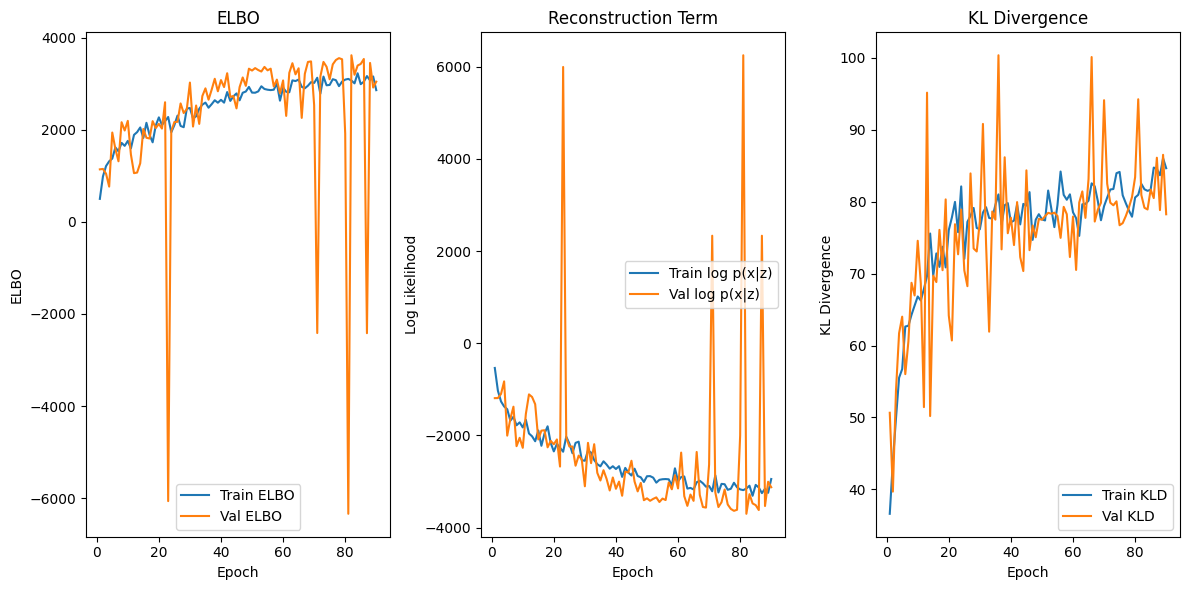

In [3]:
num_epochs = 90
train_elbo = []
val_elbo = []
train_KLD = []
val_KLD = []
train_BCE = []
val_BCE = []

for epoch in range(1, num_epochs+1):
    gaussian.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        recon_mu, recon_logvar, mu, logvar = gaussian(x)
        loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()
    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo.append(avg_train_elbo)
    train_BCE.append(total_rec / len(train_ds))
    train_KLD.append(total_kld / len(train_ds))

    gaussian.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            recon_mu, recon_logvar, mu, logvar = gaussian(x)
            loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()
    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo.append(avg_val_elbo)
    val_BCE.append(total_val_rec / len(val_ds))
    val_KLD.append(total_val_kld / len(val_ds))
    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_BCE) >= 15:
        average_last_10_val_BCE = sum(val_BCE[-10:]) / 10
        average_last_15_val_BCE = sum(val_BCE[-15:]) / 15
        if average_last_15_val_BCE - average_last_10_val_BCE < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation BCE.")
            #break

# Plotting ELBO curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_elbo, label='Train ELBO')
plt.plot(range(1, num_epochs+1), val_elbo, label='Val ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_BCE, label='Train log p(x|z)')
plt.plot(range(1, num_epochs+1), val_BCE, label='Val log p(x|z)')
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.legend()
plt.title('Reconstruction Term')

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_KLD, label='Train KLD')
plt.plot(range(1, num_epochs+1), val_KLD, label='Val KLD')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence')

plt.tight_layout()
plt.show()

In [4]:
gaussian_metrics = {
    'train_elbo': train_elbo,
    'val_elbo': val_elbo,
    'train_logpxz': train_BCE,
    'val_logpxz': val_BCE,
    'train_KLD': train_KLD,
    'val_KLD': val_KLD
}

In [5]:
#save the model to file
torch.save(gaussian.state_dict(), 'conv_vae_mnist.pth')

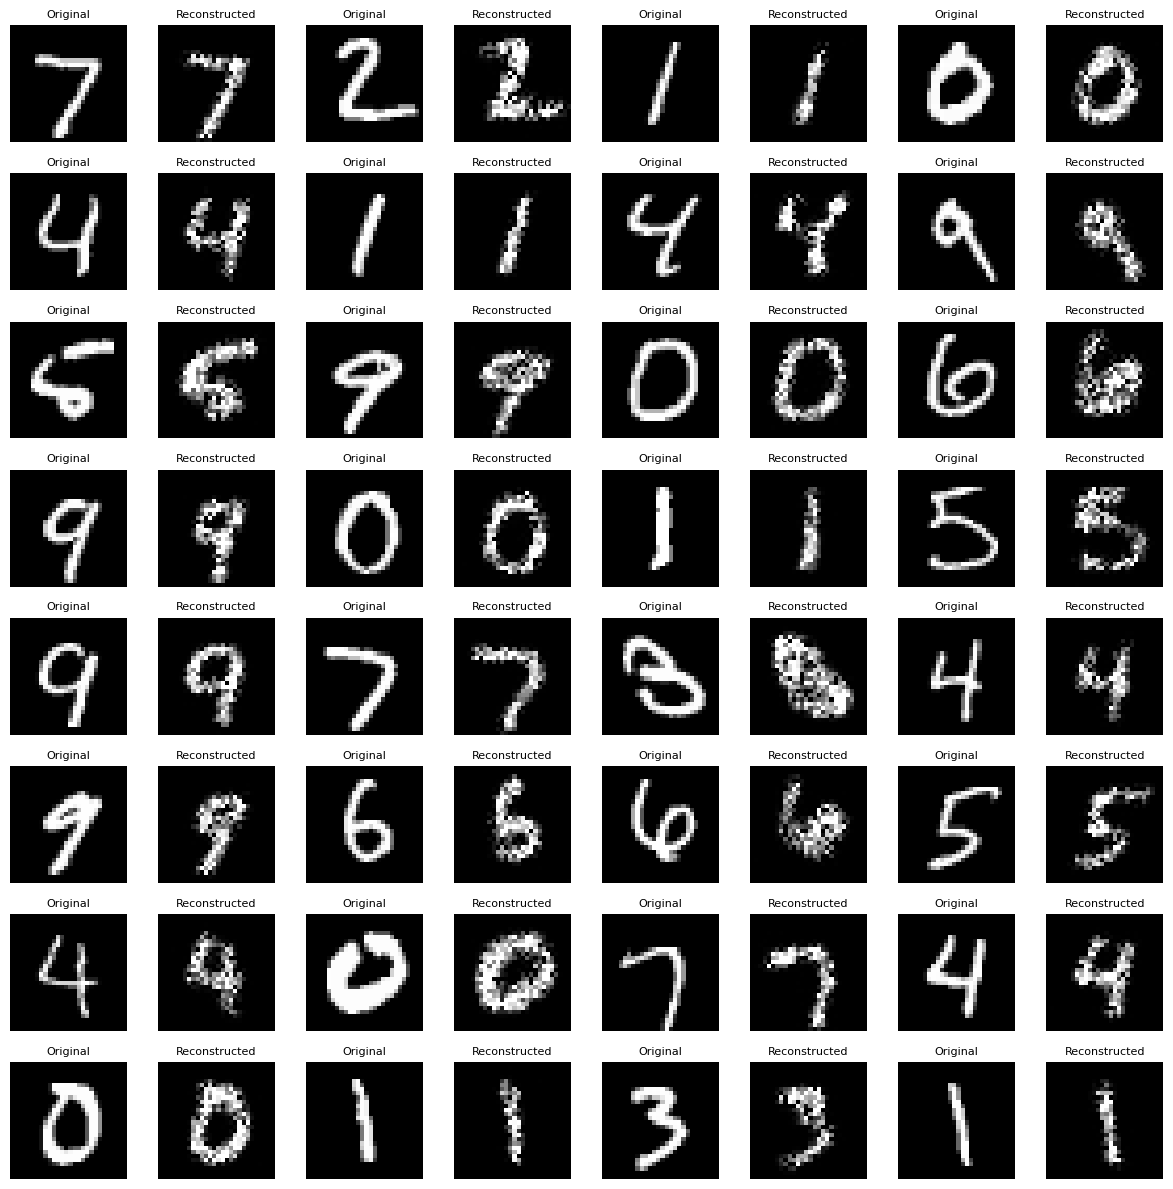

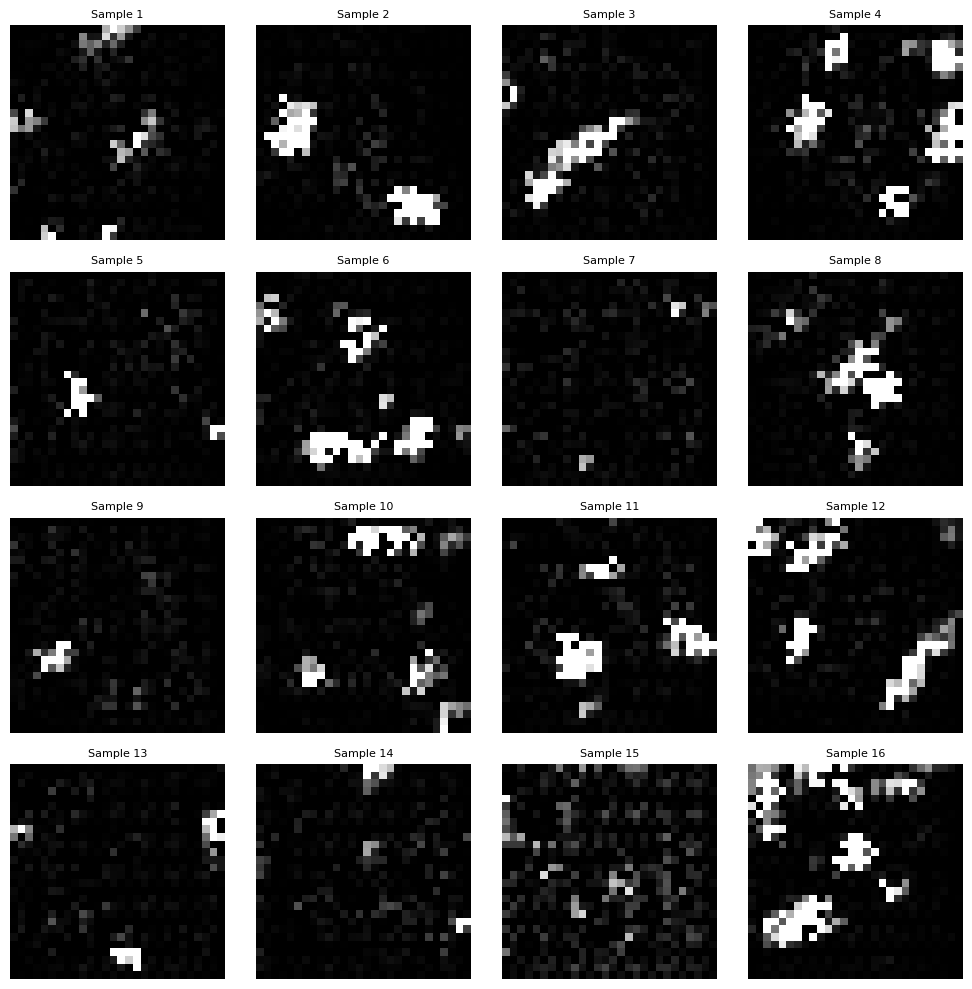

In [6]:
#load the model from file
gaussian = ConvVAE(latent_dim=20).to(device)
gaussian.load_state_dict(torch.load('conv_vae_mnist.pth'))

# Reconstructions
gaussian.eval()
with torch.no_grad():
    # Get first 32 test images
    test_batch = next(iter(dl_test))
    test_batch = test_batch[0][:32].to(device)  # Take first 32 images and move to device
    
    # Get reconstructions
    mu, logvar = gaussian.encode(test_batch)
    z = gaussian.reparameterize(mu, logvar)
    recon_mu, recon_logvar = gaussian.decode(z)
    reconstructions = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
    # Clip reconstructions to [0, 1] range
    reconstructions = torch.clamp(reconstructions, 0, 1)
    
    # Create grid: [orig1, recon1, orig2, recon2, ...]
    grid_images = []
    for i in range(32):
        grid_images.append(test_batch[i].cpu())
        grid_images.append(reconstructions[i].cpu())
    
    # Plot 8×8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i].squeeze().cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
        # Label columns
        if i % 2 == 0:
            ax.set_title("Original", fontsize=8)
        else:
            ax.set_title("Reconstructed", fontsize=8)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150)
    plt.show()



# Sample from prior
z = torch.randn(16, 20).to(device)  # 64 samples
recon_mu, recon_logvar = gaussian.decode(z)
generated = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
# Clip generated images to [0, 1] range
generated = torch.clamp(generated, 0, 1)

# Plot 8×8 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].cpu().detach().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i+1}", fontsize=8)
plt.tight_layout()
plt.savefig('generations.png', dpi=150)
plt.show()


# Task 2


In [7]:
class ConvVAE_Beta(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1)
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 2, 4, stride=2, padding=1)  # 2 channels: alpha, beta

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc(z))
        h = h.view(-1, 32, 7, 7)
        h = F.relu(self.deconv1(h))
        h = self.deconv2(h)
        alpha_raw, beta_raw = h[:, :1, :, :], h[:, 1:, :, :]  # split channels
        eps = 1e-6
        alpha = F.softplus(alpha_raw) + eps
        beta = F.softplus(beta_raw) + eps
        return alpha, beta

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        alpha, beta = self.decode(z)
        return alpha, beta, mu, logvar


In [8]:
def beta_log_likelihood(x, alpha, beta, eps=1e-6):
    x = torch.clamp(x, eps, 1 - eps)  # ensure numerical stability
    term1 = torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta)
    term2 = (alpha - 1) * torch.log(x)
    term3 = (beta - 1) * torch.log(1 - x)
    return term1 + term2 + term3  # log p(x|z) per pixel

def loss_function_beta(alpha, beta, x, mu, logvar):
    log_px_z = beta_log_likelihood(x, alpha, beta)
    log_px_z = log_px_z.sum()  # sum over all pixels and batch

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -log_px_z + KLD, -log_px_z, KLD


Epoch 01, Train ELBO: 6400.2178, Val ELBO: 6619.5714
Epoch 02, Train ELBO: 6701.8731, Val ELBO: 6749.3988
Epoch 03, Train ELBO: 6794.4445, Val ELBO: 6819.7901
Epoch 04, Train ELBO: 6850.9486, Val ELBO: 6863.0787
Epoch 05, Train ELBO: 6896.9369, Val ELBO: 6908.2956
Epoch 06, Train ELBO: 6936.7652, Val ELBO: 6950.5097
Epoch 07, Train ELBO: 6973.7033, Val ELBO: 6977.8759
Epoch 08, Train ELBO: 7008.0412, Val ELBO: 7015.6107
Epoch 09, Train ELBO: 7039.2215, Val ELBO: 7037.0800
Epoch 10, Train ELBO: 7066.1480, Val ELBO: 7076.9289
Epoch 11, Train ELBO: 7089.1005, Val ELBO: 7089.6834
Epoch 12, Train ELBO: 7114.7879, Val ELBO: 7093.9255
Epoch 13, Train ELBO: 7132.0889, Val ELBO: 7138.9649
Epoch 14, Train ELBO: 7154.2991, Val ELBO: 7171.8338
Epoch 15, Train ELBO: 7176.0727, Val ELBO: 7168.6205
Epoch 16, Train ELBO: 7194.8176, Val ELBO: 7196.6419
Epoch 17, Train ELBO: 7209.3765, Val ELBO: 7160.0355
Epoch 18, Train ELBO: 7228.3721, Val ELBO: 6644.5168
Epoch 19, Train ELBO: 7234.4508, Val ELBO: 724

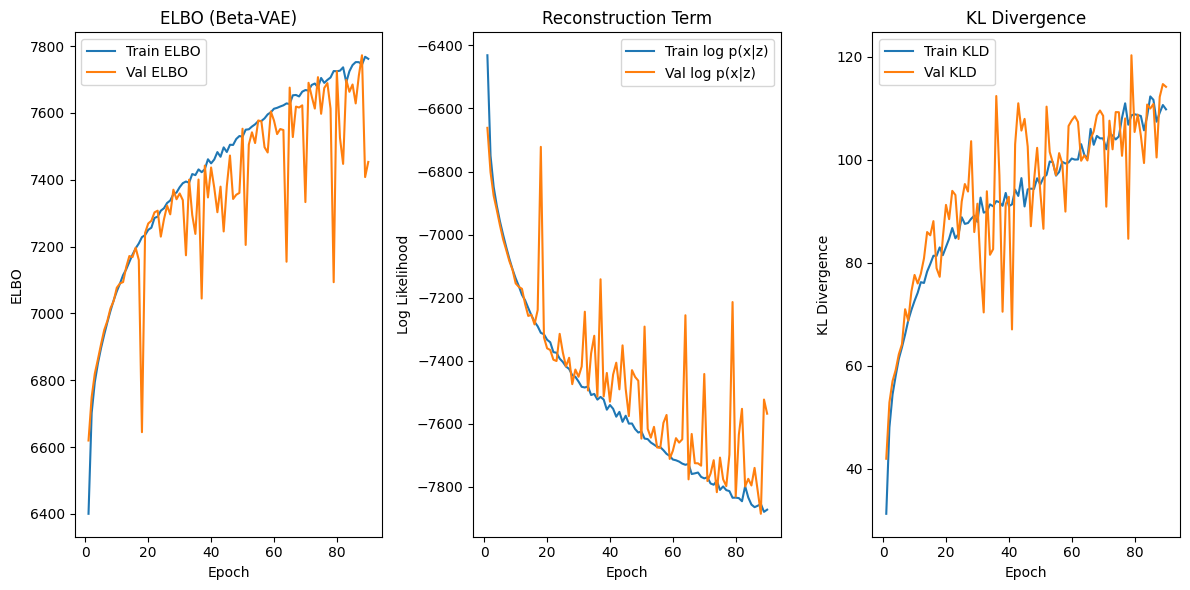

In [10]:

num_epochs = 90
train_elbo_beta = []
val_elbo_beta = []
train_KLD_beta = []
val_KLD_beta = []
train_logpxz_beta = []
val_logpxz_beta = []

model_beta = ConvVAE_Beta(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model_beta.parameters(), lr=1e-3)

# --- Training Loop ---
for epoch in range(1, num_epochs+1):
    model_beta.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        alpha, beta_params, mu, logvar = model_beta(x)
        loss, rec_term, kld = loss_function_beta(alpha, beta_params, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()

    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo_beta.append(avg_train_elbo)
    train_logpxz_beta.append(total_rec / len(train_ds))
    train_KLD_beta.append(total_kld / len(train_ds))

    model_beta.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            alpha, beta_params, mu, logvar = model_beta(x)
            loss, rec_term, kld = loss_function_beta(alpha, beta_params, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()

    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo_beta.append(avg_val_elbo)
    val_logpxz_beta.append(total_val_rec / len(val_ds))
    val_KLD_beta.append(total_val_kld / len(val_ds))

    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_logpxz_beta) >= 15:
        avg_last_10 = sum(val_logpxz_beta[-10:]) / 10
        avg_last_15 = sum(val_logpxz_beta[-15:]) / 15
        if avg_last_15 - avg_last_10 < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation log p(x|z).")
            # break


# --- Plotting ---
plt.figure(figsize=(12, 6))

# ELBO
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_elbo_beta, label='Train ELBO')
plt.plot(range(1, num_epochs+1), val_elbo_beta, label='Val ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title('ELBO (Beta-VAE)')

# Log p(x|z)
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_logpxz_beta, label='Train log p(x|z)')
plt.plot(range(1, num_epochs+1), val_logpxz_beta, label='Val log p(x|z)')
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.legend()
plt.title('Reconstruction Term')

# KL Divergence
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_KLD_beta, label='Train KLD')
plt.plot(range(1, num_epochs+1), val_KLD_beta, label='Val KLD')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence')

plt.tight_layout()
plt.show()


In [11]:

results_beta = {
    "train_elbo": train_elbo_beta,
    "val_elbo": val_elbo_beta,
    "train_logpxz": train_logpxz_beta,
    "val_logpxz": val_logpxz_beta,
    "train_KLD": train_KLD_beta,
    "val_KLD": val_KLD_beta,
}


In [12]:
torch.save(model_beta.state_dict(), 'conv_vae_beta.pth')

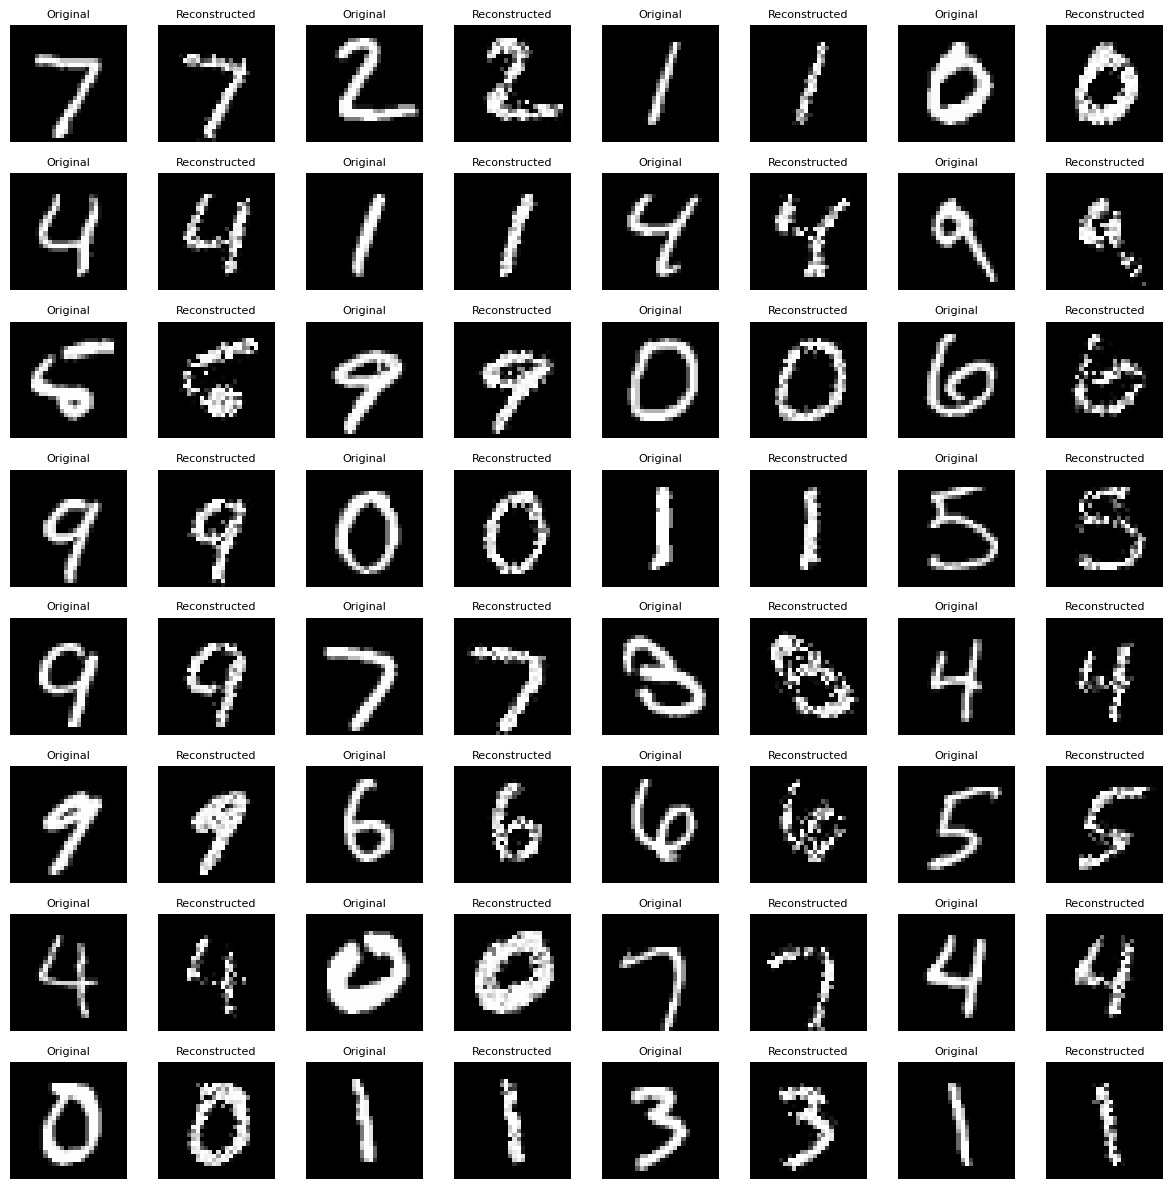

In [13]:
# Load the Beta-VAE model
model_beta = ConvVAE_Beta(latent_dim=20).to(device)
model_beta.load_state_dict(torch.load('conv_vae_beta.pth'))

# Reconstructions from test data
model_beta.eval()
with torch.no_grad():
    test_batch = next(iter(dl_test))[0][:32].to(device)

    alpha_out, beta_out, _, _ = model_beta(test_batch)
    reconstructions = torch.distributions.Beta(alpha_out, beta_out).sample()
    reconstructions = torch.clamp(reconstructions, 0, 1)

    # Interleave original and reconstructed
    grid_images = []
    for i in range(32):
        grid_images.append(test_batch[i].cpu())
        grid_images.append(reconstructions[i].cpu())

    # Plot 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i].squeeze().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title("Original" if i % 2 == 0 else "Reconstructed", fontsize=8)
    plt.tight_layout()
    plt.savefig('reconstructions_beta.png', dpi=150)
    plt.show()


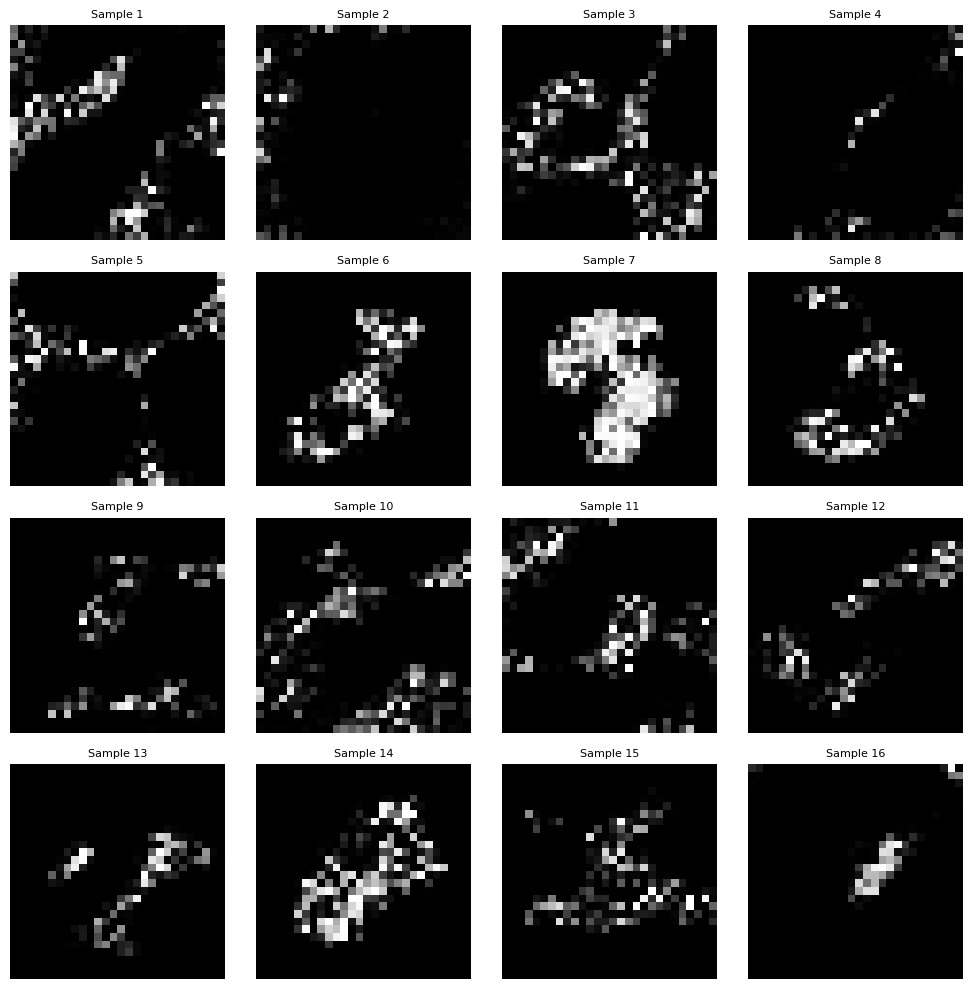

In [14]:
# Sampling from latent space using Beta decoder
z = torch.randn(16, 20).to(device)

# Use the model instance with a distinct name
alpha_out, beta_out = model_beta.decode(z)
generated = torch.distributions.Beta(alpha_out, beta_out).sample()
generated = torch.clamp(generated, 0, 1)

# Plot 4x4 grid of generated samples
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i+1}", fontsize=8)

plt.tight_layout()
plt.savefig('generations_beta.png', dpi=150)
plt.show()


In [18]:
total_logpxz_gaussian = []
total_logpxz_beta = []

for x, _ in dl_val:
    x = x.to(device)

    # Gaussian decoder
    mu, logvar = gaussian.encode(x)
    z = gaussian.reparameterize(mu, logvar)
    recon_mu, recon_logvar = gaussian.decode(z)
    _, logpxz_gaussian, _ = loss_function(recon_mu, recon_logvar, x, mu, logvar)
    total_logpxz_gaussian.append(logpxz_gaussian.item() / x.shape[0])

    # Beta decoder
    mu, logvar = model_beta.encode(x)
    z = model_beta.reparameterize(mu, logvar)
    alpha_out, beta_out = model_beta.decode(z)
    logpxz_beta = beta_log_likelihood(x, alpha_out, beta_out)
    total_logpxz_beta.append(logpxz_beta.sum().item() / x.shape[0])


print(f"Avg log p(x|z): Gaussian = {np.mean(total_logpxz_gaussian):.2f}, Beta = {np.mean(total_logpxz_beta):.2f}")


Avg log p(x|z): Gaussian = -3124.59, Beta = 7571.47
